In [1]:
pip install -q tensorflow_datasets

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow-metadata 0.25.0 requires absl-py<0.11,>=0.9, but you'll have absl-py 0.11.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
def plot_graphs(history, metric):
    
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

## Input Pipeline

In [7]:
dataset, info = tfds.load("imdb_reviews", with_info=True,
                         as_supervised=True)

train_dataset, test_dataset = dataset["train"], dataset["test"]

train_dataset.element_spec

Shuffling and writing examples to /Users/amvillalobos/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteA0QP1P/imdb_reviews-train.tfrecord


Shuffling and writing examples to /Users/amvillalobos/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteA0QP1P/imdb_reviews-test.tfrecord


Shuffling and writing examples to /Users/amvillalobos/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteA0QP1P/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /Users/amvillalobos/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [8]:
for example, label in train_dataset.take(1):
    print(f"text: {example.numpy()}")
    print(f"label: {label.numpy()}")

text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label: 0


In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b"Some comments here on IMDb have likened Dog Bite Dog to the classic Cat III films of the 90s, but although it is undoubtedly brutal, violent and very downbeat, this film from Pou-Soi Cheang isn't really sleazy, lurid or sensationalist enough to earn that comparison. However, it still packs a punch that makes it worth a watch, particularly if gritty, hard-edged action is your thing.<br /><br />Edison Chen plays Pang, a Cambodian hit-man who travels to Hong Kong to assassinate the wife of a judge; Sam Lee is Wai, the ruthless cop who is determined to track him down, whatever the cost. With Wai closing in on his target, Pang will stop at nothing to ensure his escape\xc2\x97until he meets Yue, a pretty illegal immigrant who needs his help to escape her life of abuse.<br /><br />A relentlessly harsh drama with great cinematography, amazing sound design, a haunting score, and solid performances from Chen and Lee (as well as newcomer Pei Pei as Pang's love interest), Dog Bite Dog i

## Create the Text Encoder

In [13]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [14]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [15]:
example

<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b"Some comments here on IMDb have likened Dog Bite Dog to the classic Cat III films of the 90s, but although it is undoubtedly brutal, violent and very downbeat, this film from Pou-Soi Cheang isn't really sleazy, lurid or sensationalist enough to earn that comparison. However, it still packs a punch that makes it worth a watch, particularly if gritty, hard-edged action is your thing.<br /><br />Edison Chen plays Pang, a Cambodian hit-man who travels to Hong Kong to assassinate the wife of a judge; Sam Lee is Wai, the ruthless cop who is determined to track him down, whatever the cost. With Wai closing in on his target, Pang will stop at nothing to ensure his escape\xc2\x97until he meets Yue, a pretty illegal immigrant who needs his help to escape her life of abuse.<br /><br />A relentlessly harsh drama with great cinematography, amazing sound design, a haunting score, and solid performances from Chen and Lee (as well as newcomer Pei 

In [16]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 47, 761, 132, ...,   0,   0,   0],
       [ 57, 341,   6, ...,   0,   0,   0],
       [  2, 114,   4, ...,   0,   0,   0]])

With the current settings, the vectorization process is not biyective. Three reasons:

1. The default value of TextVectorization "standardize" argument is "lower_and_strip_punctuation".
2. The limited VOCAB_SIZE and lack of character-based fallback results in some unknown tokens

In [17]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b"Some comments here on IMDb have likened Dog Bite Dog to the classic Cat III films of the 90s, but although it is undoubtedly brutal, violent and very downbeat, this film from Pou-Soi Cheang isn't really sleazy, lurid or sensationalist enough to earn that comparison. However, it still packs a punch that makes it worth a watch, particularly if gritty, hard-edged action is your thing.<br /><br />Edison Chen plays Pang, a Cambodian hit-man who travels to Hong Kong to assassinate the wife of a judge; Sam Lee is Wai, the ruthless cop who is determined to track him down, whatever the cost. With Wai closing in on his target, Pang will stop at nothing to ensure his escape\xc2\x97until he meets Yue, a pretty illegal immigrant who needs his help to escape her life of abuse.<br /><br />A relentlessly harsh drama with great cinematography, amazing sound design, a haunting score, and solid performances from Chen and Lee (as well as newcomer Pei Pei as Pang's love interest), Dog Bite Dog

# Create the Model

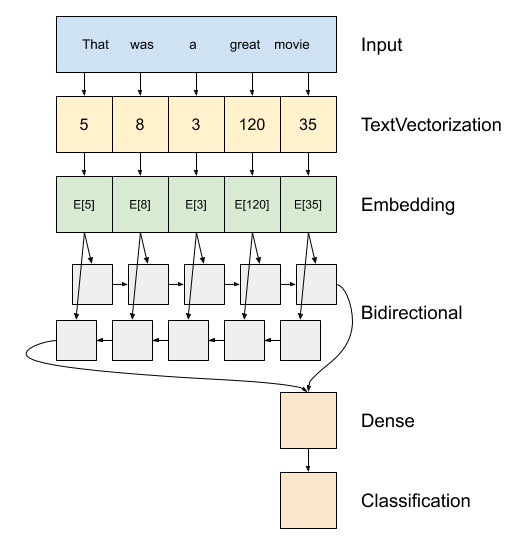

In [23]:
from IPython.display import Image
Image(filename = "img/bidirectional.png", width = 600, height = 300)


The structure of the model is the following:
1. Sequential Model
2. The input are the sentences.
3. The sentences are vectorized using the TextVectorization layer. This layer converts the text to a sequence of token indices.
4. The Embedding Layer. This layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training, words with similar meanings often have similar vectors.
5. An RNN processes sequence input by iterating through the elments. RNNS pass the outputs from one time-step to their input on the next timestep. The Bidirectional Layer wrapper can be used on RNNs. This propagates the input forward and backward through the RNN and then concatenates the final output.
    a. Advantage of the Bidirectional RNN: The input signal doesnt need to be processed all the way through every timestep to affect the output.
    b. Disadvantage: Can't efficiently stream predictions as words are being added to the end.
    

    
6. A Dense Layer (receives RNN vector) and a Logit Classifier.

In [24]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True # Handle variale sequence length
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [26]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [29]:
# Predict on a sample text wthout padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.02132091]


In [31]:
# Predict onm a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.02132091]


# Compile

In [32]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(1e-4),
             metrics=["accuracy"])

# Train the Model

In [34]:
history = model.fit(train_dataset, epochs=10,
                   validation_data=test_dataset,
                   validation_steps=30)

Epoch 1/10
218/391 [===============>..............] - ETA: 2:04 - loss: 0.6898 - accuracy: 0.5011

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

pritn(f"Test Loss: {test_loss}")
pritn(f"Test Accuracy: {test_acc}")